# Phase 4 Project Notebook

- Authors:  Steven Yan, Ivanko Zakharchuk
- Instructors:  Fangfang Lee, Justin Tannenbaum 


# EDA

## Importing Packages

In [24]:
import pandas as pd  
import numpy as np
import re
import pickle
import string
import matplotlib.pyplot as plt

import plotly
from plotly import graph_objs
plotly.offline.init_notebook_mode()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from textblob import Word

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve

from yellowbrick.style import set_palette
set_palette('yellowbrick')

from utils import *
%reload_ext autoreload
%autoreload 2

## Cornell Dataset

We started with this dataset because it contains the tweet text already, while most datasets only contain IDs.  As part of the application, we specified that we would only use IDs in the publication of the dataset.  It allowed us to start working on the preprocessing steps to get through the dataset.



In [2]:
df = pd.read_csv("data/labeled_data.csv")
df.head()

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [3]:
df.shape

(24783, 7)

In [4]:
df = df.drop("Unnamed: 0", axis=1)
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive'})

## Target Variable

Once we have identified our target variable, we want to visualize the distribution.  The figure below indicates that overwhelmingly tweets categorized as offensive totaling over 19,000, while hate tweets comprise a mere 1430.  

The major challenge of automated hate speech detection is the separation of hate speech from offensive language. The methodology behind this study was to collect tweets that contained terms from the Hatebase.org lexicon.  

Hate speech, as defined by ALA, is any form of expression intending to vilify, humiliate, or incite hatred against a group or an individual on the basis of race, religion, skin color, sexual or gender identity, ethnicity, disability, or national origin.

While it is protected by the First Amendment, if it incites criminal activity or threats of violence against a person or group, then it can be criminalized.

In [5]:
hate = len(df[df['class'] == 0])
off = len(df[df['class'] == 1])
neu = len(df[df['class'] == 2])
dist = [
    graph_objs.Bar(
        x=["hate","offensive","neutral"],
        y=[hate, off, neu],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Class Distribution")})

## Reassign Labels

In [6]:
df['class'] = df['class'].replace([2], 1)
df['class'] = df['class'].replace([0, 1], [1, 0])
df = df.rename(columns={"class": "target"})

## Preprocessing Function

Here is the thought process involved with each of the specific steps we identified working with the dataset to prepare the data for the modeling process:

- We removed callouts or usernames, which is preceded by @.  They contain no useful information.
- We removed character references, which includes HTML character references, but also emojis, unicode characters. We decided not to convert any emojis into sentiment words.
- We removed the hash from the hashtags and decided to keep the hashtag text because they are often words or word-like and are used  to connect similar ideas across the platform.  We could analyze the hashtags in a future project.
- We removed the Twitter codes RT and QT for retweet and quotetweet.  We decided to keep the retweet words, while others have removed all the text after RT.
- We removed the HTML links since a lot of users linking a website reference as part of the tweet.
- We then removed any punctuation. We did not convert contractions into the uncontracted words.
- We then lowercased all the tweets for tokenizing.
- We removed any numbers and number containing words for tokenization and vectorizing.
- We removed any extra whitespace(s) between words and any leading and trailing whitespaces.

Additional steps before modeling includes stopword removal, tokenization, lemmatizing, stemming, and/or vectorizing.


In [7]:
preprocess_tweet(df, 'tweet')

## Train-Test Split

In [8]:
X = df.tweet
y = df.target
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
train = pd.concat([X_tr, y_tr], axis=1).reset_index()
train = train.drop(columns=['index'], axis=1)
train.head()

tweet  target
0  well how else will white ppl get us to forget ...       1
1  funny thing isits not just the people doing it...       0
2                  nigga messed with the wrong bitch       0
3                                 bitch ass nigggaaa       0
4                                 so that real bitch       0

In [10]:
val = pd.concat([X_val, y_val], axis=1).reset_index()
val = val.drop(columns=['index'], axis=1)

## Removing Stopwords/Short Words and Tokenizing

We removed the punctuation from the stopwords since we already removed the apostrophes.  We could do a more thorough analysis to capture more stopwords to add to the stopwords list.

In [11]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]

train.tweet = train.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))
val.tweet = val.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))

train_tokens = tokenize(train, 'tweet')
val_tokens = tokenize(val, 'tweet')
train_tokenz = no_stopwords(train_tokens)
val_tokenz = no_stopwords(val_tokens)

## Visualizing Difference Between Hate and Offensive

In [12]:
zero = train[train.target == 0]
one = train[train.target == 1]

zero_tokens = tokenize(zero, 'tweet')
one_tokens = tokenize(one, 'tweet')
zero_tokenz = no_stopwords(zero_tokens)
one_tokenz = no_stopwords(one_tokens)


## Frequency Distributions

In [13]:
# vec = CountVectorizer()
# docs = vec.fit_transform(zero_tokenz)
# features = vec.get_feature_names()
# visualizer = FreqDistVisualizer(features=features, orient='h', n=25, size=(1080, 720))
# visualizer.fit(docs)
# custom_viz = visualizer.ax
# custom_viz.set_xlabel('Number of Tokens', fontsize=20) 
# custom_viz.set_ylabel('Token', fontsize=20)
# custom_viz.set_title("Frequency Distribution of Top 25 Tokens for Non-Hate Tweets", fontsize=24)
# custom_viz.figure.show()

<img src="images/freq_dist_non_hate.png">

In [14]:
# vec = CountVectorizer()
# docs = vec.fit_transform(one_tokenz)
# features = vec.get_feature_names()

# visualizer = FreqDistVisualizer(features=features, orient='h', n=25, size=(1080, 720))
# visualizer.fit(docs)
# custom_viz = visualizer.ax
# custom_viz.set_xlabel('Number of Tokens', fontsize=20) 
# custom_viz.set_ylabel('Token', fontsize=20)
# custom_viz.set_title("Frequency Distribution of Top 25 Tokens for Hate Tweets", fontsize=24)
# custom_viz.figure.show()

<img src="images/freq_dist_hate.png">

## WordClouds for Imbalanced Dataset

The wordclouds 

(-0.5, 399.5, 199.5, -0.5)

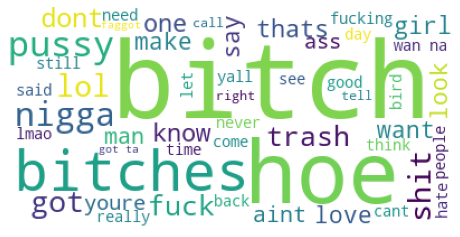

In [15]:
text = ' '.join(zero_tokenz)

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

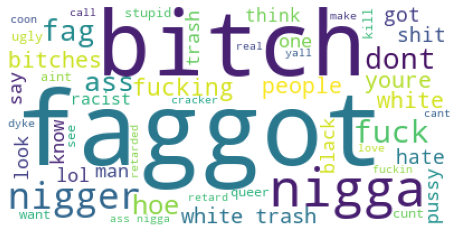

In [16]:
text = ' '.join(one_tokenz)

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

In [17]:
hate_list = np.setdiff1d(one_tokenz, zero_tokenz)
hate_list

array(['absolved', 'accord', 'acknowledged', 'activity', 'aflcio', 'aged',
       'agg', 'ahhhahahaha', 'ahmed', 'airlines', 'aklve', 'alaqsa',
       'alcoholics', 'alls', 'alsarabsss', 'amazement', 'americathey',
       'amigo', 'anglo', 'anon', 'antiracist', 'antisemite',
       'antizionist', 'apartheid', 'appearance', 'argentino', 'ariza',
       'arkansas', 'aryan', 'aslina', 'attorney', 'axin', 'azflooding',
       'azmonsoon', 'backpedals', 'baiters', 'baka', 'balless',
       'ballless', 'banner', 'banwagoning', 'barge', 'barnyard',
       'bateman', 'batshit', 'bazinga', 'bdubs', 'beamthat', 'beiber',
       'believes', 'belton', 'benghazzi', 'benton', 'bernstine', 'beta',
       'bias', 'bibles', 'bidens', 'bikes', 'birthdayyyy', 'bisexual',
       'bitcheslook', 'blacklisted', 'blaspheme', 'blondeproblems',
       'boris', 'boyraping', 'brainwash', 'brainwashed', 'bran', 'brits',
       'bromance', 'broner', 'buckcity', 'buffets', 'buku', 'bulldozed',
       'bundle', 'butc

The traditional epithets are not found in exclusively in the hate category, only the less traditional words often in the form of hashtags can be found exclusively as hate speech.  That would make sense. in terms pf

- sexual orientation:  teabagged, girlboy, azflooding, azmonsoon, molester, cousintoucher, theyfaggots, dicklicker
- sex:  wenchs
- race/ethnicity/religion:  osamas, spicskkk, niggerous, nigglets. nigress, ovenjew, westvirginia, texarkana, ching, chong, maoists, mexicannigger

One clear distinction is the difference in use of nigga versus the n word.  When people say the f word against homosexuals, it is more often in the derogatory sense.  The p word can be just offensive or sexist, i.e. males use the p word to denigrate guys, which can be offensive but not considered hate speech. 

## Stemming and Lemmatization

Since there is so much colloquial use of words amongst tweets, we did not anticipate that stemming or lemmatization to have a significant impact on the predictive value of the model.  

In [18]:
train_stem = stemming(train_tokenz)
val_stem = stemming(val_tokenz)

In [19]:
from nltk.corpus import stopwords
lemmatization(train)
lemmatization(val)
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]
train.lem = train['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
val.lem = val['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))

0    well how else will white ppl get forget our ho...
1    funny thing isits not just the people doing it...
2                    nigga messed with the wrong bitch
3                                    bitch as nigggaaa
4                                      that real bitch
Name: lem, dtype: object

0                           got missed call from bitch
1    fucking with bad bitch you gone need some mone...
2    lol credit aint where near good but know the r...
3    wipe the cum out them faggot contact lens wild...
4    nigga cheat they bitch and dont expect pay bac...
Name: lem, dtype: object

# Baseline Model

In [20]:
X_tr = train.lem
X_val = val.lem
y_tr = train.target
y_val = val.target

## TD-IDF Vectorizer

In [21]:
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

Training F1 Score:  0.012195121951219513
Validation F1 Score:  0.0
Training Recall Score:  0.0061403508771929825
Validation Recall Score:  0.0
Training Precision Score:  0.875
Validation Precision Score:  0.0
Training Average Precision Score:  0.30883247804093567
Validation Average Precision Score:  0.16283262448260288


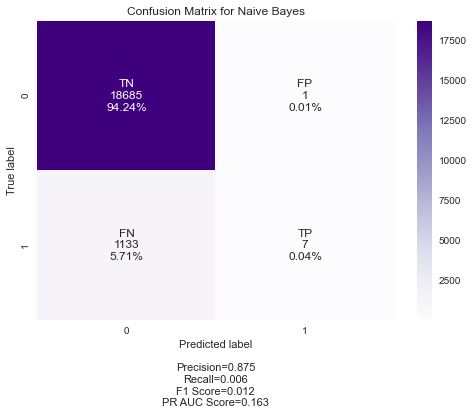

In [33]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)

make_confusion_matrix(cf = confusion_matrix(y_tr, y_pr_nb_tr),
                      X = tfidf_val,
                      y = y_val,
                      model = nb,
                      cmap='Purples',
                      title='Confusion Matrix for Naive Bayes')

## Random Forest Classifier

Training F1 Score:  0.9824868651488616
Validation F1 Score:  0.19944598337950137
Training Recall Score:  0.9842105263157894
Validation Recall Score:  0.12413793103448276
Training Precision Score:  0.9807692307692307
Validation Precision Score:  0.5070422535211268
Training Average Precision Score:  0.9852601324302912
Validation Average Precision Score:  0.3022896801121844


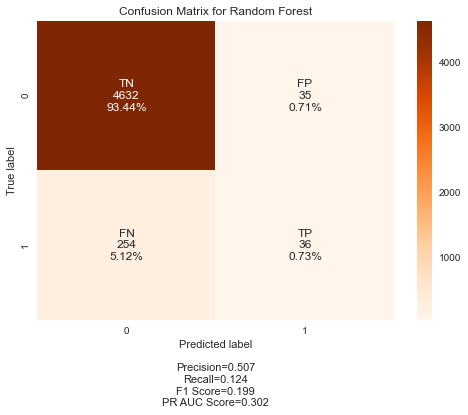

In [34]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

make_confusion_matrix(cf = confusion_matrix(y_val, y_pr_rf_val),
                      X = tfidf_val,
                      y = y_val,
                      model = rf,
                      cmap='Oranges',
                      title='Confusion Matrix for Random Forest')

## Logistic Regression

Training F1 Score:  0.25584795321637427
Validation F1 Score:  0.18487394957983194
Training Recall Score:  0.15350877192982457
Validation Recall Score:  0.11379310344827587
Training Precision Score:  0.7675438596491229
Validation Precision Score:  0.4925373134328358
Training Average Precision Score:  0.5826117025159812
Validation Average Precision Score:  0.3497021490008816


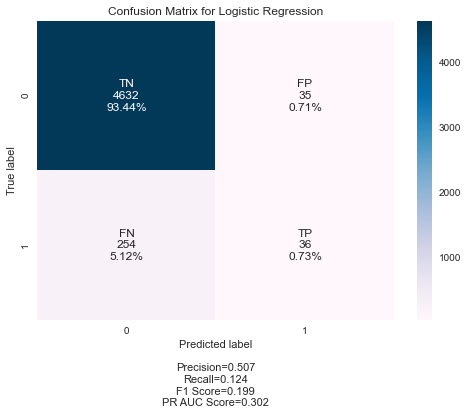

In [35]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

make_confusion_matrix(cf = confusion_matrix(y_val, y_pr_rf_val),
                      X = tfidf_val,
                      y = y_val,
                      model = rf,
                      cmap='PuBu',
                      title='Confusion Matrix for Logistic Regression')

# API Calling (University of Copenhagen Dataset)

To address class imbalance, we went to a dataset where 136,052 tweets were retrieved and 3383 annotated as sexist, 1972 as racist, and 11559 as neither.  Sexist tweets contained n-grams that consisted of the following words:  woman, girl, bitch, feminist, sexist, and racist tweets contained n-grams that consists of the following words: islam and muslim.

The hate tweet IDs were compiled and sent to the Twitter API to retrieve the corresponding tweet text, and not all the API calls produced a result.  Ultimately, another 3000 labeled hate tweets were added to the original labeled dataset.

Since this was a European study, that would make sense contextually.  Once again, it would be hard to discern between offensive and hate tweets based on those sexist terms. All of those words could be part of normal discourse.

In [58]:
df2 = pd.read_csv('data/hate_add.csv')
df2.columns = ['id', 'label']
df2.label.value_counts()

none      11559
sexism     3378
racism     1969
Name: label, dtype: int64

# Fixing Class Imbalance

##  With additional labeled as hate speech data and API Requests we were able to get more twits and balance main dataset.
###  The code for requests and balansing can be found in data_collection.ipynb

# Load Corpus and Look at the Data

In [13]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()


import re
import string

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [6]:
df = pd.read_csv("data/balanced_data_combined.csv")
df = df.drop(columns = 'Unnamed: 0')

In [7]:
print(df.shape)
df.head()

(8337, 2)


text  class
0  Drasko they didn't cook half a bird you idiot ...      1
1  Hopefully someone cooks Drasko in the next ep ...      1
2  of course you were born in serbia...you're as ...      1
3  These girls are the equivalent of the irritati...      1
4  RT @YesYoureRacist: At least you're only a tin...      1

In [8]:
# class 0 - not hate speech
# class 1 - hate speech

In [9]:
# Crreate class description for each row in data
df['class_descr'] = df['class'].map(lambda x: 'hate_speech' if x==1 else 'not_hate_speech')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8335 non-null   object
 1   class        8337 non-null   int64 
 2   class_descr  8337 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.5+ KB


In [11]:
# Drop NaN values in text column

df.dropna(subset=['text'], inplace=True)

# Visualize Amount of  tweets classes

Text(0.5,1,'Amount of Tweets Per Label')

Text(0.5,0,'Type of Tweet')

Text(0,0.5,'Count')

[Text(0,0,'Not Hate Speech'), Text(0,0,'Hate Speech')]

Text(0,4166,'49.95%')

Text(1,4175,'50.05%')

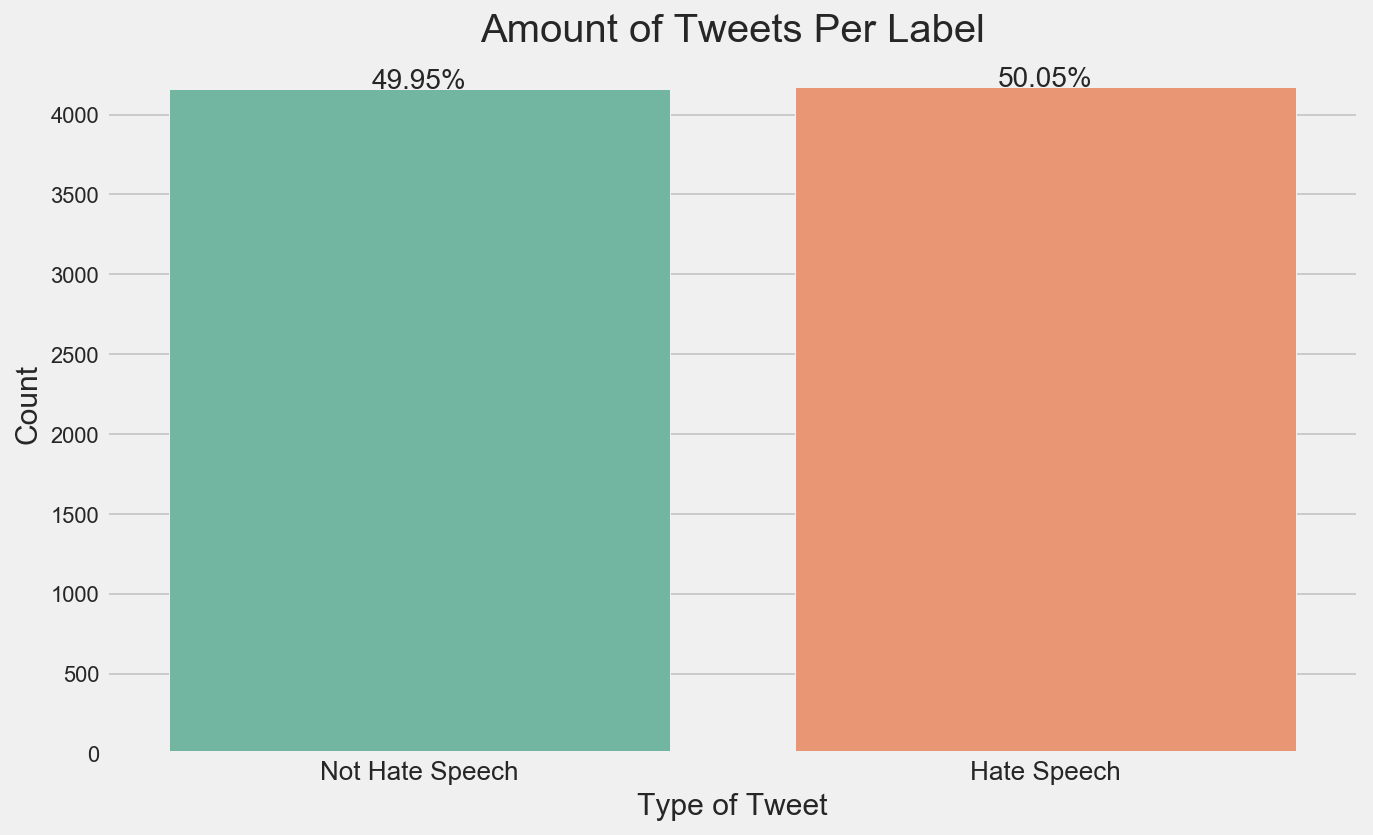

In [15]:
#print(df['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

# Create Document - Term Matrix

* Preprotcessing and cleaning 
* Tokenize
* Stemming and Lemming
* Document-Term Matrix

## Data Preprotcessing and Cleaning

In [16]:
# removing excess
# removing punctuation
# lovercase letters 
# remove numbers or numerical values
# remove non-sesial text (/n)

In [17]:
# Create function with text cleaning techniques usinx regex

def clean_text_step1(text):
    '''
    Looking for speciffic patterns in the text and 
    removing them or replacing with space
    Function returns string
    '''
        
    # make text lowercase
    text = text.lower()
    
    # string punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # removing patterns and replace it with nothing
    text = re.sub('\[.*?\]', '', text)
 
    # removing digits if they surounded with text or digit
    text = re.sub('\w*\d\w*', '', text)
    
    # make just 1 space if there is more then 1
    text = re.sub('\s+', ' ', text)
    
    # replace new line symbol with space
    text = re.sub('\n', ' ', text)
    
    # removing any quotes
    text = re.sub('\"+', '', text)
    
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    
    # cleaning from user name
    text = re.sub('(@[^\s]+)', '', text)
    
    # looking for # and replacing it
    text = re.sub('(#[^\s]+)', '', text)
    
    # removing `rt`
    text = re.sub('(rt)', '', text)

    # looking for `httptco`
    text = re.sub('(httptco)', '', text)
    
    # looking for `mkr`
    text = re.sub('(mkr)', '', text)
    
    text = re.sub('(sexist)', '', text)
    
    text = re.sub('(like)', '', text)
    
    text = re.sub('(women)', '', text)

    return text

In [18]:
# applying function for cleaning text data

df['text'] = df['text'].apply(clean_text_step1)

In [19]:
df.head()

text  class  class_descr
0      drasko they didnt cook half a bird you idiot       1  hate_speech
1  hopefully someone cooks drasko in the next ep of       1  hate_speech
2  of course you were born in serbiayoure as fuck...      1  hate_speech
3  these girls are the equivalent of the irritati...      1  hate_speech
4   yesyoureracist at least youre only a tiny bit...      1  hate_speech

In [20]:
# Function to filter data with words that contain more then 2 characters
def txt_filtering(row, n =2):
    new_words = []
    for w in row['text'].split(' '):
        if len(w) > 2:
            new_words.append(w)
    row['text'] = ' '.join(new_words)
    return row

In [21]:
df = df.apply(txt_filtering, axis = 1)

## Tokenization Data (splitting into smaller pieces) and removing stopwords

In [22]:
stopwords_list = stopwords.words('english')

In [23]:
def tokenize_text(text):
    
    """
    Tocanize document and create visualization of most recent words
    Wiil filter data with stopwords
    """
    tokens = nltk.word_tokenize(text)
    
    stopwords_removed = [token for token in tokens if token not in stopwords_list] 
    
    return stopwords_removed

In [24]:
processed_data = list(map(tokenize_text, df['text']))

## Lets Plot frequency distribution of tokens in corpus

In [25]:
def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for tweet in data:
        for word in tweet:
            words_lst.append(word)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30, title = "Frequency distribution of words within corpus")
    plt.show()

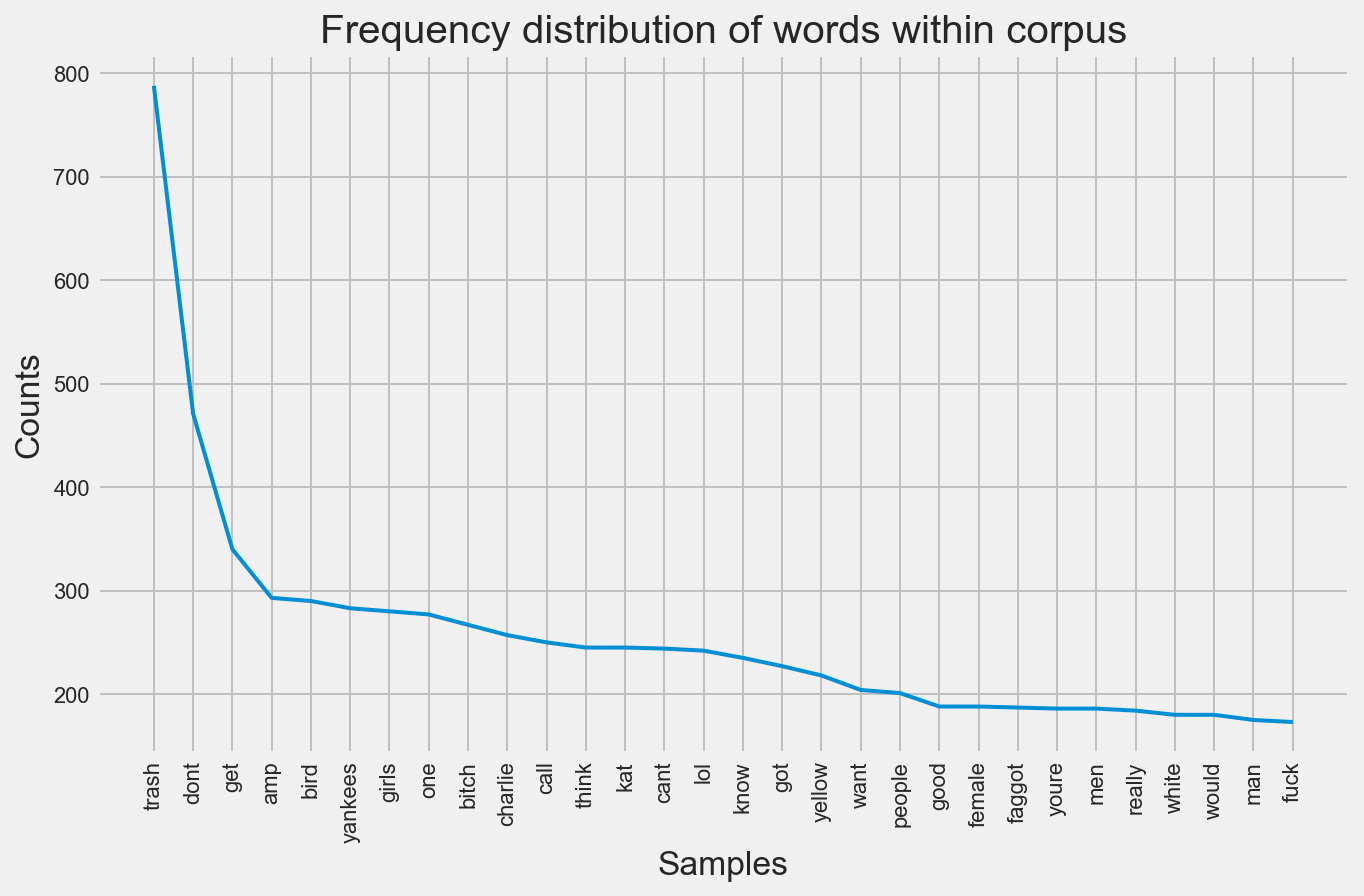

In [26]:
plot_frequency(processed_data)

In [27]:
processed_data[:2]

[['drasko', 'didnt', 'cook', 'half', 'bird', 'idiot'],
 ['hopefully', 'someone', 'cooks', 'drasko', 'next']]

In [28]:
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

17984

## Create Docunent-Term Matrix

In [30]:
# look at the corpus
df.head()

text  class  class_descr
0         drasko they didnt cook half bird you idiot      1  hate_speech
1            hopefully someone cooks drasko the next      1  hate_speech
2  course you were born serbiayoure fucked serbia...      1  hate_speech
3  these girls are the equivalent the irritating ...      1  hate_speech
4  yesyoureracist least youre only tiny bit racis...      1  hate_speech

In [31]:
# Using CountVextorizer from sklearn 
# in data_dtm each row represents different document
# and each collumn represents word from vocab

cv = CountVectorizer(stop_words = 'english')
df_cv = cv.fit_transform(df.text)
data_dtm = pd.DataFrame(df_cv.toarray(), columns= cv.get_feature_names())
data_dtm.index = df.index
data_dtm.head()

aaaaaaaaand  aaand  aamaadmipay  aamattyhealy  aamessinger  aan  \
0            0      0            0             0            0    0   
1            0      0            0             0            0    0   
2            0      0            0             0            0    0   
3            0      0            0             0            0    0   
4            0      0            0             0            0    0   

   aandapples  aap  aarcayne  aaron  ...  zstonecipher  ztsupreme  zucchini  \
0           0    0         0      0  ...             0          0         0   
1           0    0         0      0  ...             0          0         0   
2           0    0         0      0  ...             0          0         0   
3           0    0         0      0  ...             0          0         0   
4           0    0         0      0  ...             0          0         0   

   zwaaad  zwithr  zyhosbrfff  zzachbarness  zzzquil  zzzz  zzzzzz  
0       0       0           0             0        0     0       0  
1       0       0           0             0        0     0       0  
2       0       0           0             0        0     0       0  
3       0       0           0             0        0     0       0  
4       0       0           0             0        0     0       0  

[5 rows x 17778 columns]

# Lematizing Data

In [32]:
# function to creat a list with all lemmatized words

def lematizing_text(data):
    
    """
    Lematizing words from the corpus data
    Returns list of strings with lematized 
    words in each string
    """
    
    lemmatizer = WordNetLemmatizer() 
    lemmatized_output = []

    for tweet in data:
        lemmed = ' '.join([lemmatizer.lemmatize(w) for w in tweet])
        lemmatized_output.append(lemmed)
        
    return lemmatized_output

In [33]:
lemmatized_data = lematizing_text(processed_data)

In [34]:
lemmatized_data[:5]

['drasko didnt cook half bird idiot',
 'hopefully someone cook drasko next',
 'course born serbiayoure fucked serbian film',
 'girl equivalent irritating asian girl couple year ago well done',
 'yesyoureracist least youre tiny bit racist racist dick']

## Most Frequent Words for Each Class

In [35]:
df_freq_hate = df[df['class']==1]
df_freq_not_hate = df[df['class']==0]

In [36]:
data_hate = df_freq_hate['text']
data_not_hate = df_freq_not_hate['text']

In [37]:
def freq_wrds_class(data, n = 20, show= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(map(tokenize_text, data))
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if show:
        print('Total words in vocab : {}'.format(len(total_vocab)))
        print (30*'-')
        print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        return freq.most_common(n)
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    
    return freq

In [38]:
# Top 20 hate words:
freq_wrds_class(data_hate, show=True)

Total words in vocab : 9703
------------------------------
Top 20 most frequent words:


[('dont', 302),
 ('bitch', 257),
 ('girls', 245),
 ('kat', 244),
 ('call', 210),
 ('get', 196),
 ('faggot', 187),
 ('think', 178),
 ('female', 176),
 ('fuck', 173),
 ('cant', 170),
 ('men', 165),
 ('ass', 152),
 ('one', 147),
 ('know', 146),
 ('nigga', 139),
 ('woman', 137),
 ('white', 133),
 ('fucking', 132),
 ('hate', 128)]

In [39]:
# Top 20 non-hate words:
freq_wrds_class(data_not_hate)

Total words in vocab : 11672
------------------------------
Top 20 most frequent words:


[('trash', 672),
 ('bird', 287),
 ('yankees', 281),
 ('charlie', 257),
 ('yellow', 213),
 ('dont', 169),
 ('birds', 167),
 ('amp', 166),
 ('get', 144),
 ('lol', 140),
 ('got', 131),
 ('one', 130),
 ('monkey', 111),
 ('ghetto', 109),
 ('colored', 108),
 ('good', 94),
 ('know', 89),
 ('new', 88),
 ('love', 84),
 ('day', 84)]

## Normalized word frequencies:

In [41]:
def normalized_word_fqncy(data, n=25):
    
    frqncy = freq_wrds_class(data, n, show = False)
    total_w_count = sum(frqncy.values())
    top = frqncy.most_common(25)
    print("Word \t\t Normalized Frequency")
    print()
    for word in top:
        normalized_frequency = word[1]/total_w_count
        print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [42]:
normalized_word_fqncy(data_hate)

Word 		 Normalized Frequency

dont 		 0.009045
bitch 		 0.007697
girls 		 0.007338
kat 		 0.007308
call 		 0.006289
get 		 0.00587
faggot 		 0.005601
think 		 0.005331
female 		 0.005271
fuck 		 0.005181
cant 		 0.005091
men 		 0.004942
ass 		 0.004552
one 		 0.004403
know 		 0.004373
nigga 		 0.004163
woman 		 0.004103
white 		 0.003983
fucking 		 0.003953
hate 		 0.003834
amp 		 0.003804
youre 		 0.003684
want 		 0.003624
people 		 0.003594
trash 		 0.003474


In [43]:
normalized_word_fqncy(data_not_hate)

Word 		 Normalized Frequency

trash 		 0.01933
bird 		 0.008254
yankees 		 0.008081
charlie 		 0.007391
yellow 		 0.006126
dont 		 0.00486
birds 		 0.004803
amp 		 0.004774
get 		 0.004141
lol 		 0.004026
got 		 0.003768
one 		 0.003739
monkey 		 0.003192
ghetto 		 0.003135
colored 		 0.003106
good 		 0.002703
know 		 0.00256
new 		 0.002531
love 		 0.002416
day 		 0.002416
game 		 0.002387
want 		 0.002387
make 		 0.002358
would 		 0.00233
people 		 0.00233


# Visualization

In [46]:
# Seperate frequency of each class

hate_freq = freq_wrds_class(data_hate, show =False)
not_hate_freq = freq_wrds_class(data_not_hate, show =False)

In [47]:
# create counts of hate and not hate with values and words

hate_bar_counts = [x[1] for x in hate_freq.most_common(25)]
hate_bar_words = [x[0] for x in hate_freq.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(25)]

In [48]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.8,.16, 30))

<BarContainer object of 25 artists>

[]

<BarContainer object of 25 artists>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 <a list of 25 Text xticklabel objects>)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 <a list of 25 Text xticklabel objects>)

Text(0.5,1.05,'Top 25 Most Frequent Words per Label')

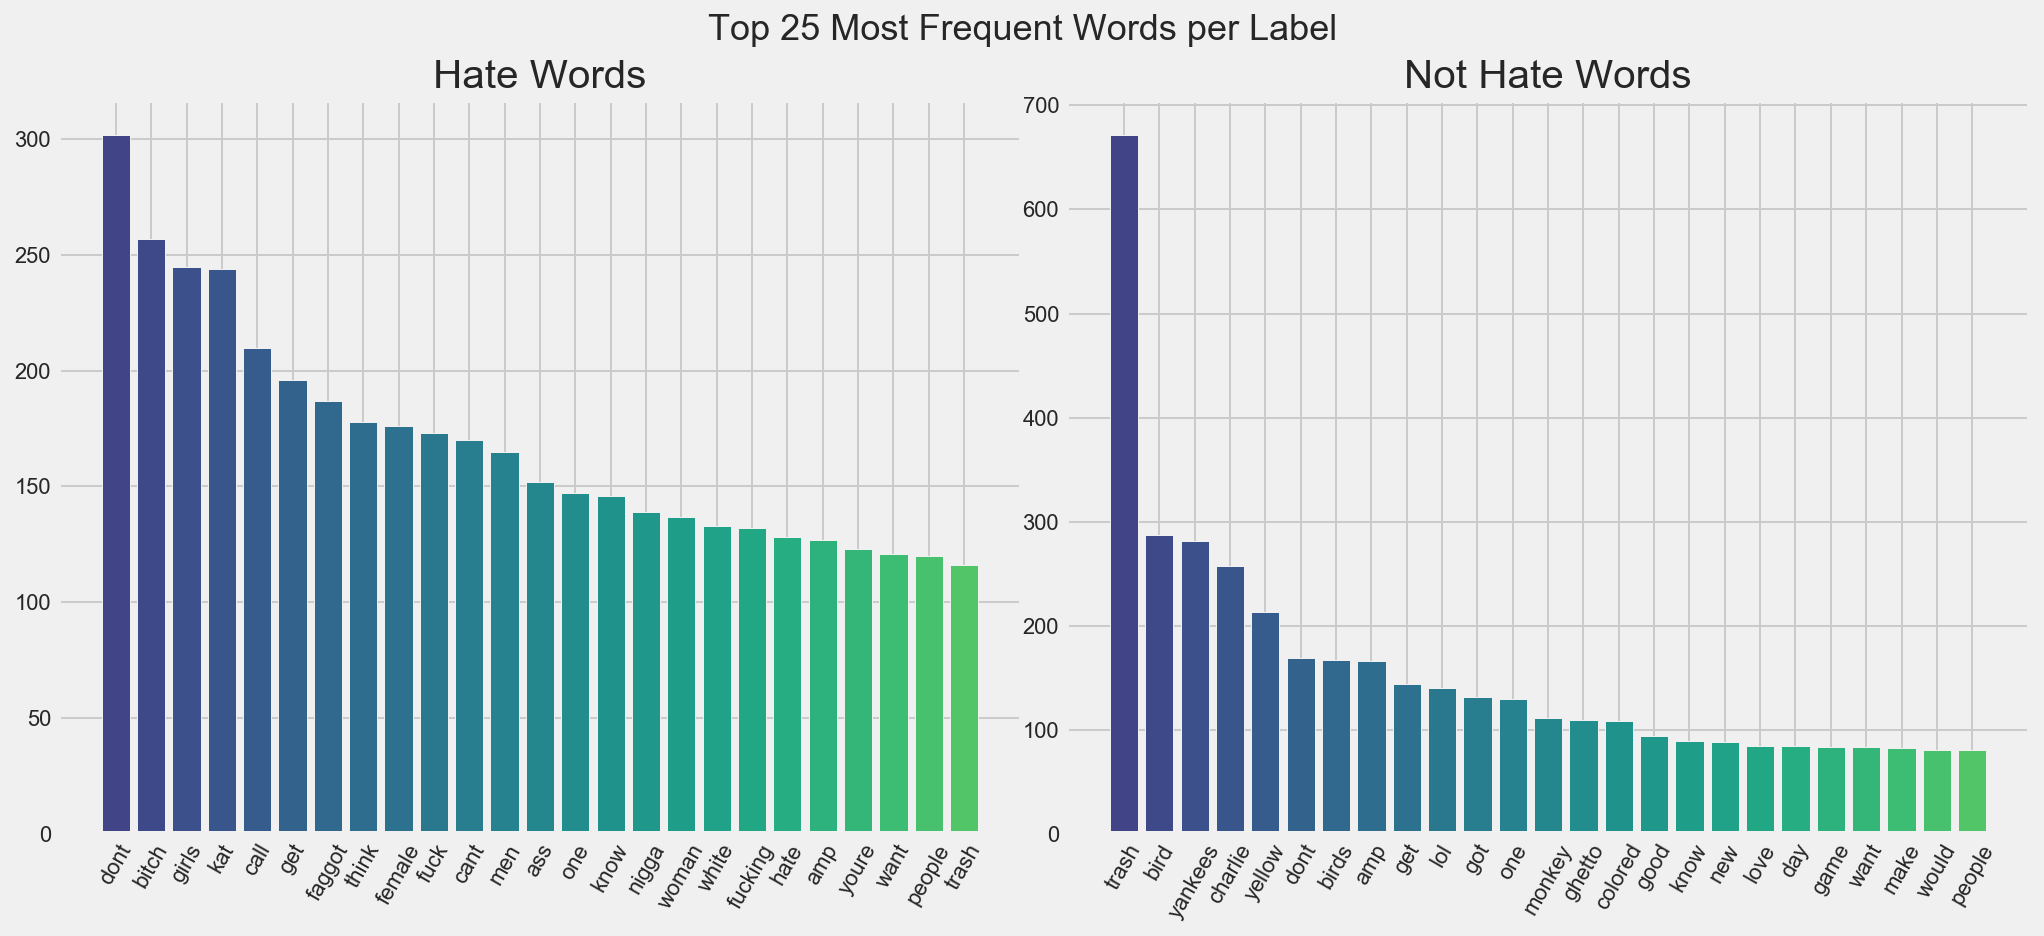

In [51]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Words')
ax2.title.set_text('Not Hate Words')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)
new_figure.suptitle('Top 25 Most Frequent Words per Label', fontsize =18, y =1.05)

# plt.savefig('images/word_count_graphs.png')

plt.show()

# Further Modeling